# Year by year comparison

## Aims

Compare SSNAP data between each year (from 2016 to 2021), with the aim of understanding whether there might be any large differences related to the COVID-19 pandemic. Uses full dataset unless stated otherwise (i.e. just restricted by number of admissions - and not by whether arrived within 4 hours of known stroke onset).

## Caveats

Looking overall (not by stroke team) - variation between them in terms of impact.

## Existing analysis

Looked into existing analysis of SSNAP data for changes over time which is on Overleaf. There were four identified examples, which typically evaluated changes with reference to the data from the same time period/quarter in a prior year. A brief summary:
* **First lockdown:** Fewer admissions, and more haemorrhagic, older and severe strokes. Increased mortality (particularly if had COVID and stroke). One concluded higher clinical quality, one found longer times and reduced proportion admitted within four hours, and receiving thrombolysis (likely due to specific time periods and comparators). etc.
* **Second lockdown:** No drop in admissions. Proportion admitted within four hours dropped. Increase in onset to arrival time. Decline in proportion receiving thrombolysis. Slight improvement in door to needle time. etc.

## Observations

* **Admissions:** Number of admissions is increasing over the years, with drop for start of 2020 (but typical number for year as a whole)
* **Age:** Mean age is decreasing over the years, with seasonal variation (higher mean age in winter)
* **Gender:** Proportion of male patients is increasing over the years, with seasonal variation (lower proportion male in winter)
* **Stroke type:** Seasonal variation in stroke type (lower proportion infarction in winter)
* **Thrombolysis:** Thrombolysis rates have dropped in 2020 and 2021
* **Thrombectomy:** Thrombectomy reates are increasing over time
* **Time to arrival and treatment:** Over the years, we typically see decreasing arrival to scan time, and increasing onset to arrival, scan to thrombolysis, and arrival to thrombectomy time
* **Proportion with known onset:** Highest in 2019
* **Stroke severity:** Generally decreasing over time, with seasonal variation (higher mean stroke severity in winter). Although there is a peak at start of first lockdown, this is not particularly out of usual variation
* **Arriving by ambulance:** Decreasing over time but with increase over COVID
* **Ambulance times:** These are only available from 2019. Median travel to hospital and hospital wait time is consistent. Median ambulance on scene time is increasing. Medican call to ambulance time decreased in 2020 and increased in 2021.
* **Comorbidities:** slightly trends over time (proportion with hypertension and diabetes increasing, and proportion with atrial firbillation and prior stroke or TIA decreasing)
* **Antiplatelets and anticoagulants:** Proportion on anticoaulants is decreasing, but anticoagulant data appears unsual (likely data quality or calculation issue that need to investigate further)
* **Prior disability:** No obvious trends over time
* **Discharge disability:** Some seasonal variation (higher proportion with worse disability scores in winter)
* **Six month disability:** No obvious trends over time
* **Mortality at discharge:** Decreasing over time with seasonal variation (higher proportion dead in winter)
* **Reasons for not receiving thrombolysis:** "No" reasons only available for a small number of patients. "No but" reasons have trends - either not consistent, or increasing (time window, medication) or decreasing (comorbidity, improving)

## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    raw_path = './../data/'
    raw_filename = 'SAMueL ssnap extract v2.csv'
    data_path = './../output/'
    admission_only_filename = 'reformatted_data_admissions_only.csv'

    notebook = '01'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(
    paths.data_path, paths.admission_only_filename))

raw_data: pd.DataFrame = pd.read_csv(
    os.path.join(paths.raw_path, paths.raw_filename), low_memory=False)

## Set up

Create column with month+year or quarter+year.

In [4]:
# Create datetime with month and year
data_full['month_year_dt'] = pd.to_datetime(
    data_full['year'].astype(str) + '-' +
    data_full['month'].astype(str), format='%Y-%m')

# Convert to period of m (month and year)
data_full['month_year'] = data_full['month_year_dt'].dt.to_period('m')

# Convert to period of q (quarter and year)
data_full['quarter_year'] = data_full['month_year_dt'].dt.to_period('q')

Add column with grouped stroke severity

In [5]:
conditions = [(data_full['stroke_severity'] == 0),
              (data_full['stroke_severity'].isin(np.arange(1, 5))),
              (data_full['stroke_severity'].isin(np.arange(5, 16))),
              (data_full['stroke_severity'].isin(np.arange(16, 21))),
              (data_full['stroke_severity'].isin(np.arange(21, 43)))]
nihss_choices = ['0', '1-4', '5-15', '16-20', '21-42']
data_full['stroke_severity_groups'] = np.select(conditions,
                                                nihss_choices)

## Functions

These are functions used in multiple sections and so stored seperately.

In [6]:
def plot_line(time, outcome, type, ax, title, legend):
    '''
    Create line plot
    time = string, column with time variable
    outcome = string, column with outcome variable
    type = string, type of operation (e.g. size, mean)
    ax = axis object to plot on
    title = string, figure title
    legend = True or False (depending on whether want to show legend)
    '''
    # Groupby timeperiod and period operation (e.g. count, proportion)
    if type == 'size':
        df = data_full.groupby(time).size().reset_index(name=outcome)
    elif type == 'mean':
        df = data_full.groupby(time)[outcome].mean().reset_index()
    elif type == 'median':
        df = data_full.groupby(time)[outcome].median().reset_index()

    # Create line plot
    df.plot.line(x=time, y=outcome, title=title, marker='o',
                 markersize=2.5, legend=None, ax=ax)

    # Add vertical line indicating start of lockdown
    if time == 'month_year':
        first = pd.Timestamp('2020-03-01').to_period('m')
        second = pd.Timestamp('2020-11-01').to_period('m')
        third = pd.Timestamp('2021-01-01').to_period('m')
    elif time == 'quarter_year':
        first = pd.Timestamp('2020-03-01').to_period('q')
        second = pd.Timestamp('2020-11-01').to_period('q')
        third = pd.Timestamp('2021-01-01').to_period('q')
    elif time == 'year':
        first = 2020
        second = 2020
        third = 2021

    ax.axvline(x=first, color='red', linestyle='--', alpha=0.3,
               label='first lockdown')
    ax.axvline(x=second, color='green', linestyle='--', alpha=0.3,
               label='second lockdown')
    ax.axvline(x=third, color='purple', linestyle='--', alpha=0.3,
               label='third lockdown')
    if legend:
        ax.legend(prop={'size': 6})


def create_line_plots(outcome, type, title_start):
    '''
    Create series of line plots (per month, per quarter and per year)
    outcome = string, column with outcome variable
    type = string, type of operation (e.g. size, mean)
    title_start = string, start of title (to then end with 'per month' etc)
    '''
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
    plot_line('month_year', outcome, type, ax[0],
              title_start + ' per month', legend=True)
    plot_line('quarter_year', outcome, type, ax[1],
              title_start + ' per quarter', legend=False)
    plot_line('year', outcome, type, ax[2],
              title_start + ' per year', legend=False)
    plt.show()


def plot_stacked_bar(time, group, order=False):
    '''
    Create stacked bar chart with the proportion of patients in
    each per specified time period
    time = string, column with time period (e.g. month_year)
    group = string, column with group (e.g. prior_disability)
    order = array, specifies column order, optional
    '''
    # Find proportions
    df = (data_full
          .groupby(time)[group]
          .value_counts(normalize=True)
          .reset_index(name='prop')
          .pivot(columns=group,
                 index=time, values='prop'))

    # Create stacked bar plot
    fig, ax = plt.subplots(figsize=(10, 5))
    if order:
        df[nihss_choices].plot(kind='bar', stacked=True, width=0.8,
                               legend=False, ax=ax)
    else:
        df.plot(kind='bar', stacked=True, width=0.8,
                legend=False, ax=ax)
    ax.set_ylabel('Proportion')

    # Add lines for each lockdown
    if time == 'month_year':
        first = df.index.get_loc('2020-03')
        second = df.index.get_loc('2020-11')
        third = df.index.get_loc('2021-01')
    if time == 'quarter_year':
        first = df.index.get_loc('2020Q1')
        second = df.index.get_loc('2020Q4')
        third = df.index.get_loc('2021Q1')
    if time == 'year':
        first = df.index.get_loc(2020)
        second = df.index.get_loc(2020)
        third = df.index.get_loc(2021)
    plt.vlines(x=first, ymin=0, ymax=1, color='red',
               linestyle='--', alpha=0.5, label='first lockdown')
    plt.vlines(x=second, ymin=0, ymax=1, color='green',
               linestyle='--', alpha=0.5, label='second lockdown')
    plt.vlines(x=third, ymin=0, ymax=1, color='purple',
               linestyle='--', alpha=0.5, label='third lockdown')

    # Create legend and display plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## Admissions

Observations:
* The general trend is that number of admissions is increasing over time
* There is a drop in admissions at the start of 2020 (but, for whole year, it is not too disimilar from prior years)
* There is a notable increase in admissions in 2021

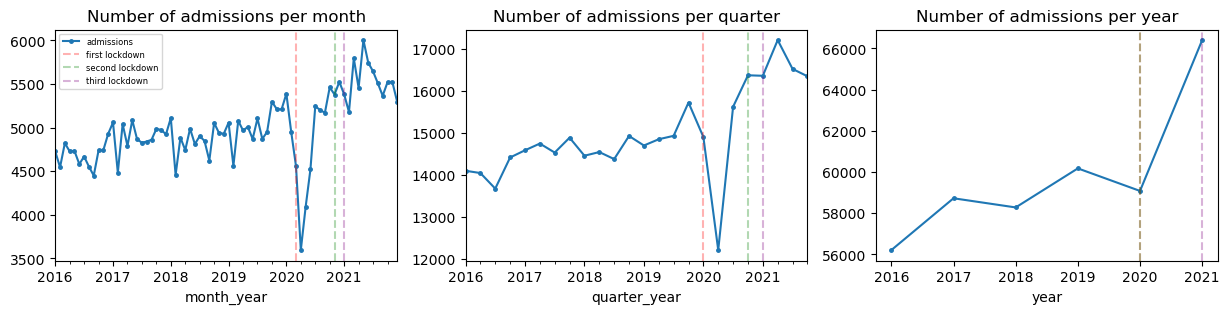

In [7]:
create_line_plots('admissions', 'size', 'Number of admissions')

## Age

Observations:
* The general trend is that mean age of patients is decreasing over time.
* There is seasonal variation - typically higher mean age in winter than in summer.

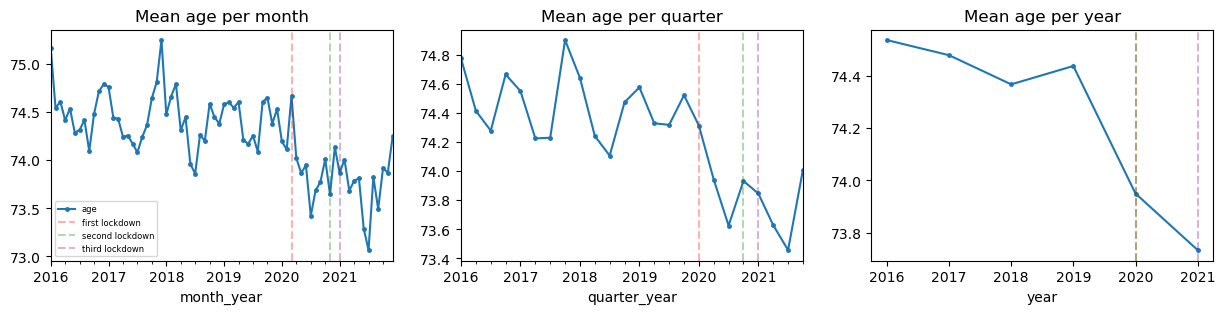

In [8]:
create_line_plots('age', 'mean', 'Mean age')

## Gender

Observations:
* The general trend is that the proportion of patients who are male is increasing over time.
* There is seasonal variation - typically lower proportion male in winter than in summer.

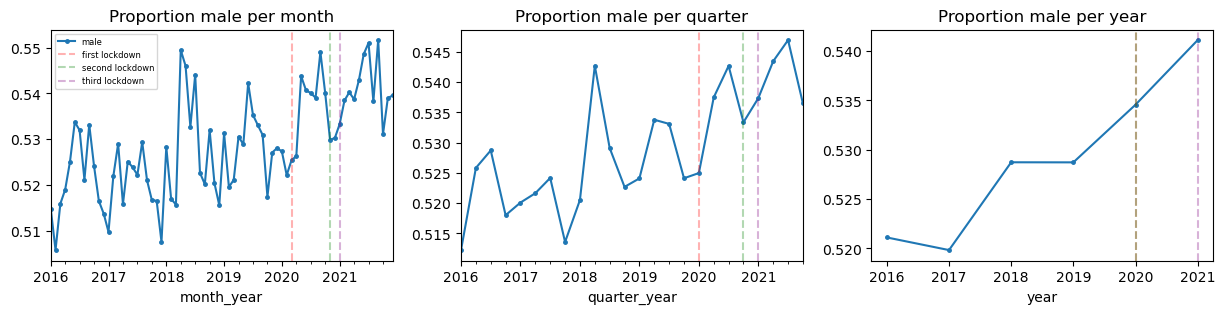

In [9]:
create_line_plots('male', 'mean', 'Proportion male')

## Ischaemic v.s. Haemorrhagic

Observations:
* There does not appear to be a general trend across the whole time period
* There is some seasonal variation - typically lower proportion infarction in winter than in summer 

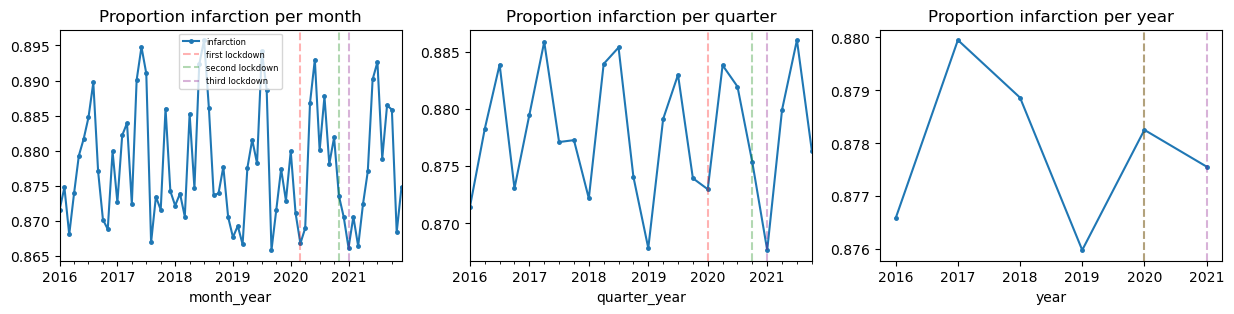

In [10]:
create_line_plots('infarction', 'mean', 'Proportion infarction')

## Thrombolysis and thrombectomy

Observations:
* The proportion **thrombolysed** was consistent from 2016 to 2019, but dropped in 2020 and 2021
* The proportion receiving **thrombectomy** is increasing over time

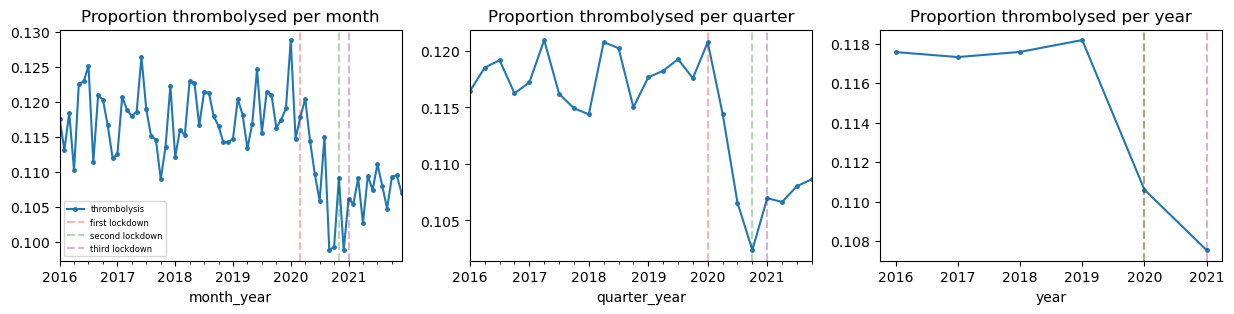

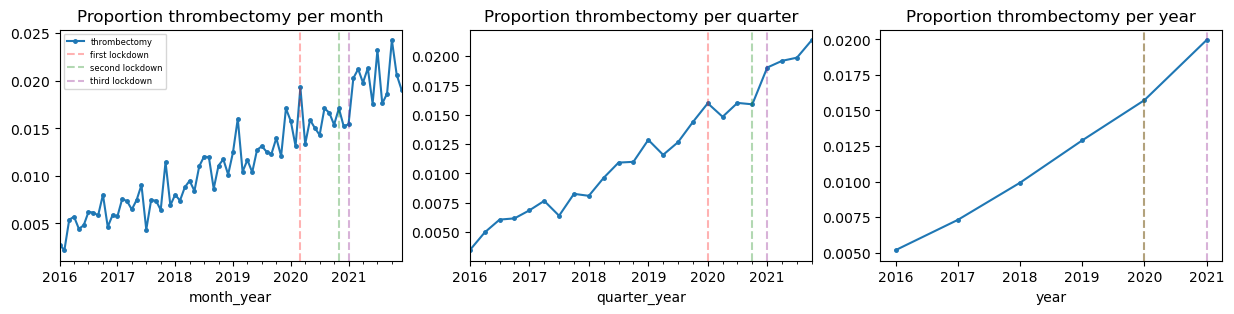

In [11]:
create_line_plots('thrombolysis', 'mean', 'Proportion thrombolysed')
create_line_plots('thrombectomy', 'mean', 'Proportion thrombectomy')

## Time to arrival and treatment

Focus on **median** times due to presence of outliers in dataset.

Observations:
* **Onset to arrival time** is getting longer
* **Arrival to scan time** was shortening but has plateued
* **Scan to thrombolysis time** was consistent until 2019 when it began to get longer
* **Arrival to thrombectomy time** is getting longer

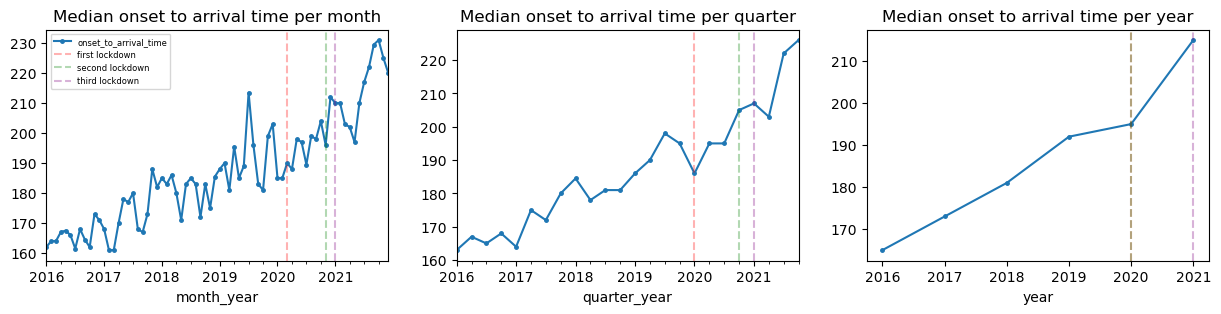

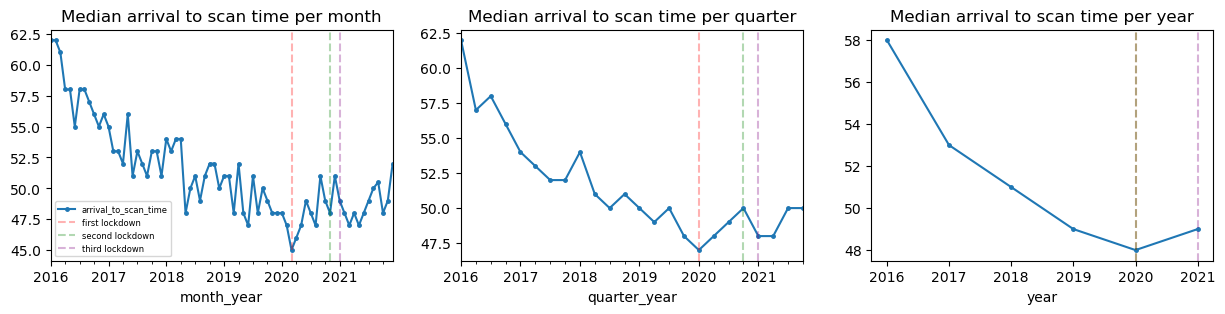

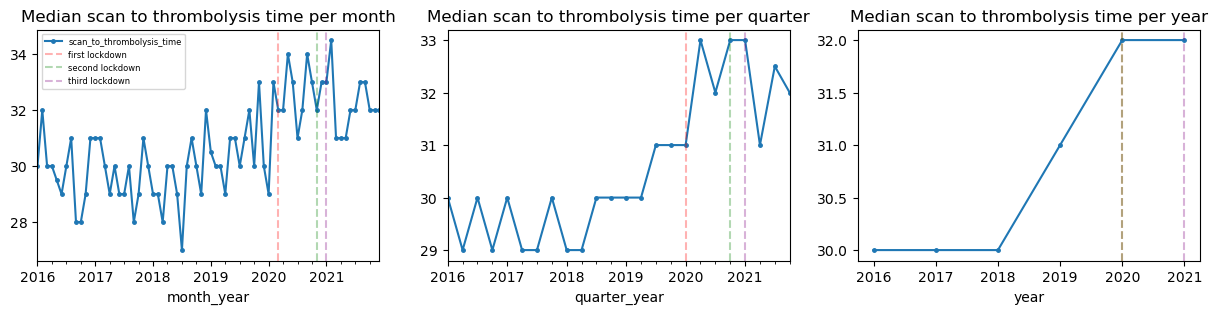

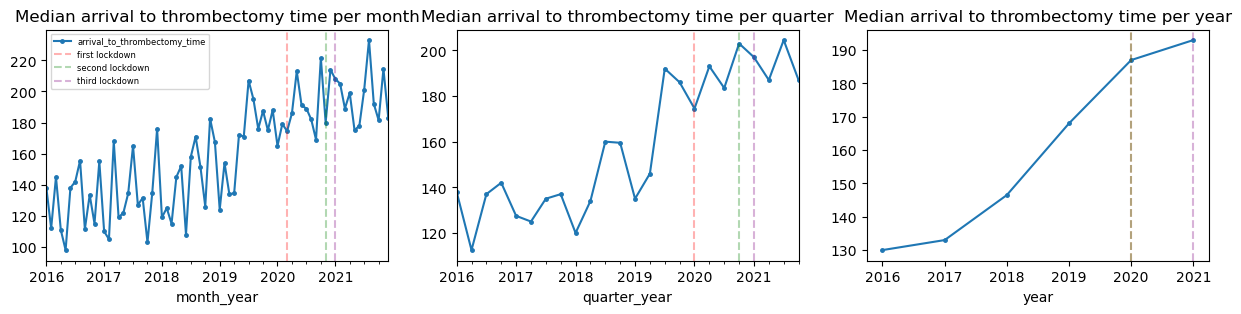

In [12]:
create_line_plots('onset_to_arrival_time', 'median',
                  'Median onset to arrival time')
create_line_plots('arrival_to_scan_time', 'median',
                  'Median arrival to scan time')
create_line_plots('scan_to_thrombolysis_time', 'median',
                  'Median scan to thrombolysis time')
create_line_plots('arrival_to_thrombectomy_time', 'median',
                  'Median arrival to thrombectomy time')

## Known onset

Observations:
* Proportion with known onset was highest in 2019
* The proportion known in 2020-2021 is similar to (if not a little higher than) 2016-2018

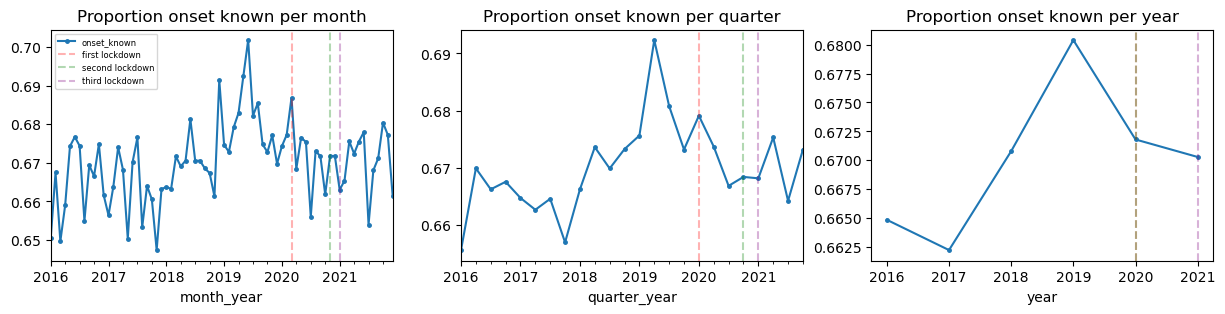

In [13]:
create_line_plots('onset_known', 'mean', 'Proportion onset known')

## Stroke severity

These graphs focus on **mean** stroke severity.

Observations:
* The general trend is that mean stroke severity is decreasing over time.
* There is apparent seasonal variation in mean stroke severity. There is a peak in the months from the start of the first lockdown, but (a) there are prior months with high peaks like in 2018, and (b) overall for the quarter and year, it doesn't appear unusual.

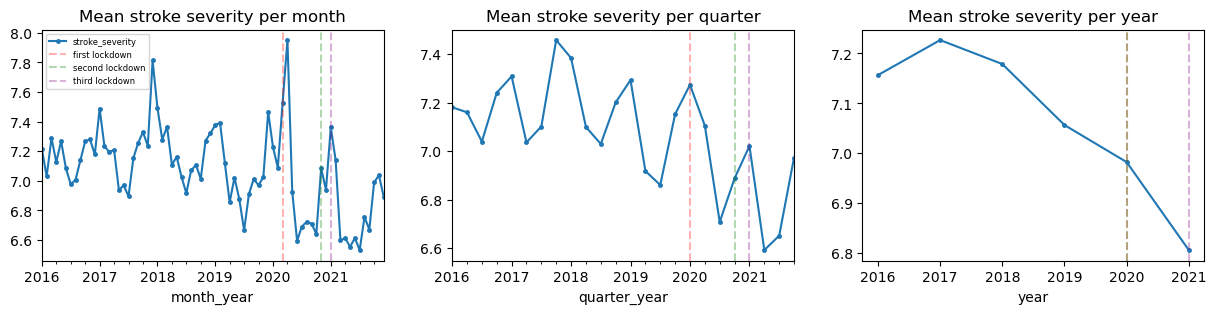

In [14]:
create_line_plots('stroke_severity', 'mean', 'Mean stroke severity')

These graphs focus on the **proportions** of people with each stroke severity.

Observations:
* From stacked bar chart, it is hard to see any patterns
* From the line chart, you can observe the variation in more detail - for example, that there is a decrease in the proportion of strokes that were mild in March/April 2020 and then an increase in May/June 2020. However, this doesn't appear to be particularly out of the range of usual variation observed, looking across the whole time period.

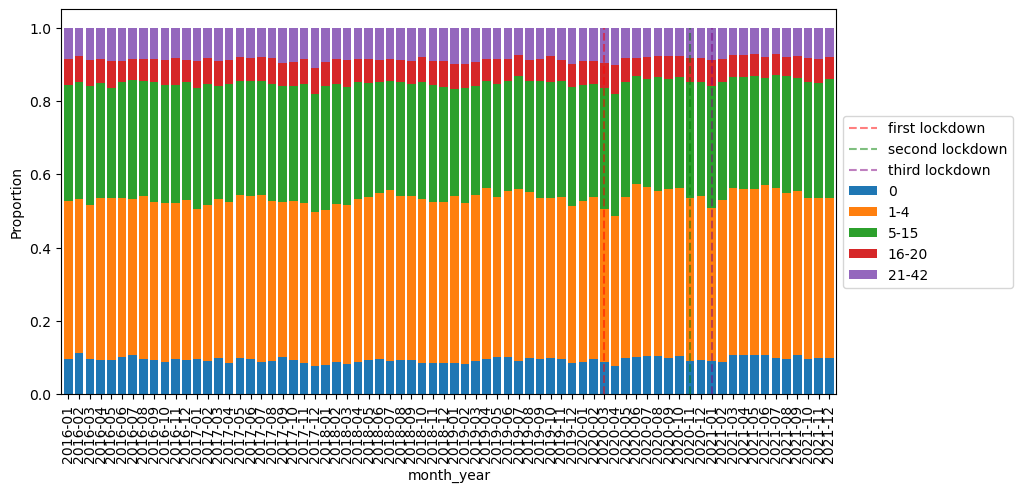

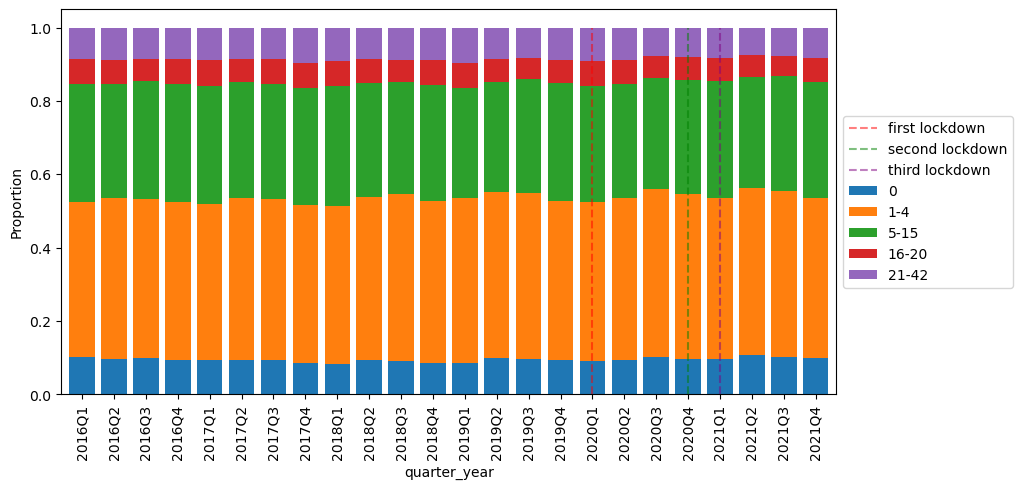

In [15]:
plot_stacked_bar('month_year', 'stroke_severity_groups', nihss_choices)
plot_stacked_bar('quarter_year', 'stroke_severity_groups', nihss_choices)

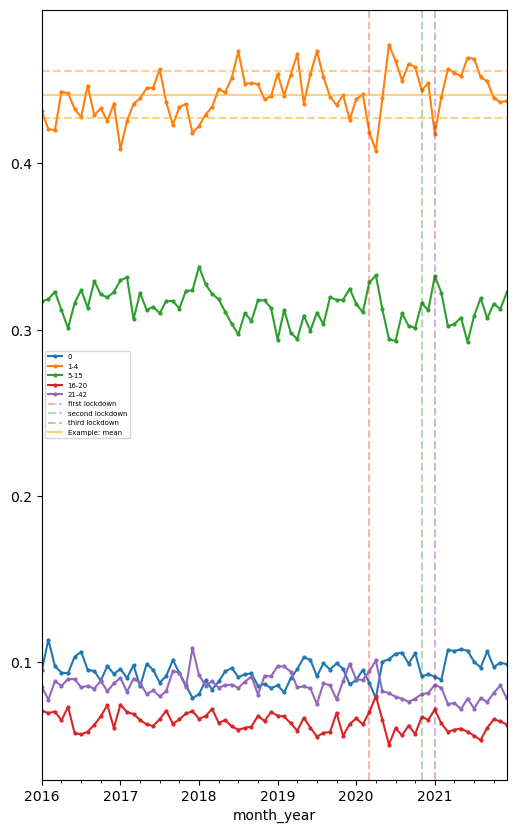

In [16]:
# Find proportion in each stroke severity group by month and year
df = (data_full
      .groupby('month_year')['stroke_severity_groups']
      .value_counts(normalize=True)
      .reset_index(name='prop'))

# Create line plot
df_monthly = df.pivot(columns='stroke_severity_groups',
                      index='month_year', values='prop')
fig, ax = plt.subplots(figsize=(6, 10))
df_monthly[nihss_choices].plot(kind='line', marker='o', markersize=2, ax=ax)

# Add vertical lines indicating each lockdown
first = pd.Timestamp('2020-03-01').to_period('m')
ax.axvline(x=first, color='red', linestyle='--', alpha=0.3,
           label='first lockdown')
second = pd.Timestamp('2020-11-01').to_period('m')
ax.axvline(x=second, color='green', linestyle='--', alpha=0.3,
           label='second lockdown')
third = pd.Timestamp('2021-01-01').to_period('m')
ax.axvline(x=third, color='purple', linestyle='--', alpha=0.3,
           label='third lockdown')

# Find mean and SD of the monthly proportions by stroke group
df_av = df.groupby('stroke_severity_groups').agg(
    {'prop': ['mean', 'std']}).reset_index()
df_av.columns = list(map(''.join, df_av.columns.values))

# Find the mean and SD for NIHSS 1-4 and add as a line
prop_mean = df_av.loc[df_av['stroke_severity_groups'] == '1-4',
                      'propmean'].values[0]
prop_std = df_av.loc[df_av['stroke_severity_groups'] == '1-4',
                     'propstd'].values[0]
plt.axhline(y=prop_mean, alpha=0.5, color='orange', label='Example: mean')
plt.axhline(y=prop_mean+prop_std, color='orange', alpha=0.5, linestyle='--')
plt.axhline(y=prop_mean-prop_std, color='orange', alpha=0.5, linestyle='--')

ax.legend(prop={'size': 5})
plt.show()

These graphs focussing on **comparing to a similar timepoint** in the previous year. This example is focussed on the **proportion with stroke NIHSS <5**.

Observations:
* Comparing months, April 2020 is quite different from April in other years. 
* Comparing quarters, 2020 doesn't appear particularly unusual.

Overall, although we can note differences for individual years (for example, proportion at start of lockdown), looking overall, these trends don't appear to be within a usual pattern of variation.

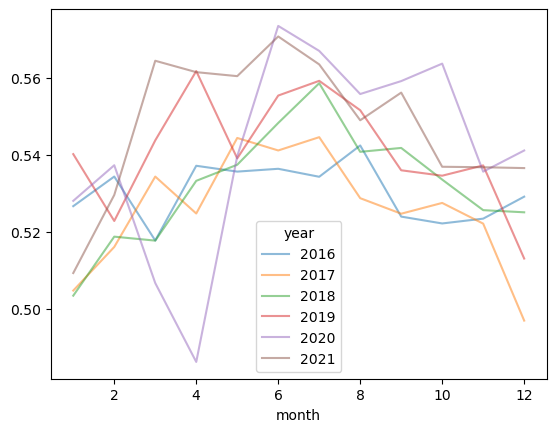

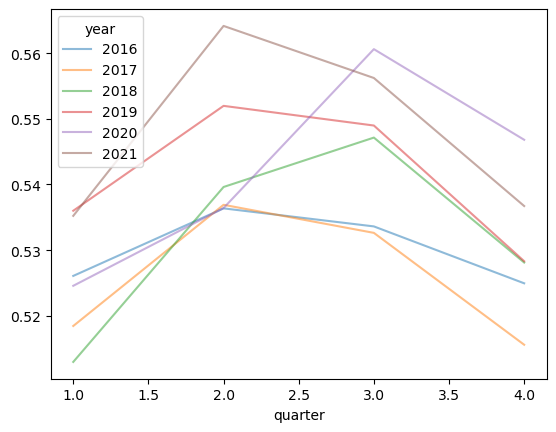

In [17]:
# Add column where is 1 if NIHSS < 5
data_full['mild'] = np.where(data_full['stroke_severity'] < 5, 1, 0)

# Find proportion with that score per month and year
df = (data_full
      .groupby(['year', 'month'])['mild']
      .mean()
      .reset_index(name='prop')
      .pivot(columns='year', index='month', values='prop'))
df.plot(kind='line', alpha=0.5)
plt.show()

# Add quarter column
data_full['quarter'] = data_full['month']//3.1+1

# Find proportion with that score per quarter and year
df = (data_full
      .groupby(['year', 'quarter'])['mild']
      .mean()
      .reset_index(name='prop')
      .pivot(columns='year', index='quarter', values='prop'))
df.plot(kind='line', alpha=0.5)
plt.show()

As per Anna's suggestion, looking at individual team trends for some years - with her logic being that if you end up with each hospital showing completely different variations, then we could more easily say that the effects aren't important on the big scale.

This example focussed on **proportion mild stroke per month in first 6 hospitals (alphabetically)**.

Observations:
* Large variation within each hospital month to month
* Don't easily see consistent trends for each year.

However, I think its likely as we're looking at **quite low numbers of patients** when breakdown by month and team (see example of counts from one hospital below) - and hence may wish to not plot like this (as such low numbers). Variation persists if look at means instead of proportions.

In [18]:
def plot_team_severity(team, col, ax, legend):
    '''
    Create line plot of the proportion of patients with mild stroke per
    year for the specified team on the specified axis
    team: string, stroke team
    ax: axis object to plot on
    legend: true/false, whether to include legend
    '''
    df = (data_full[data_full['stroke_team'] == team]
          .groupby(['year', 'month'])[col]
          .mean()
          .reset_index(name='prop')
          .pivot(columns='year', index='month', values='prop'))
    df.plot(kind='line', alpha=0.5, ax=ax)
    if not legend:
        ax.get_legend().remove()
    else:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

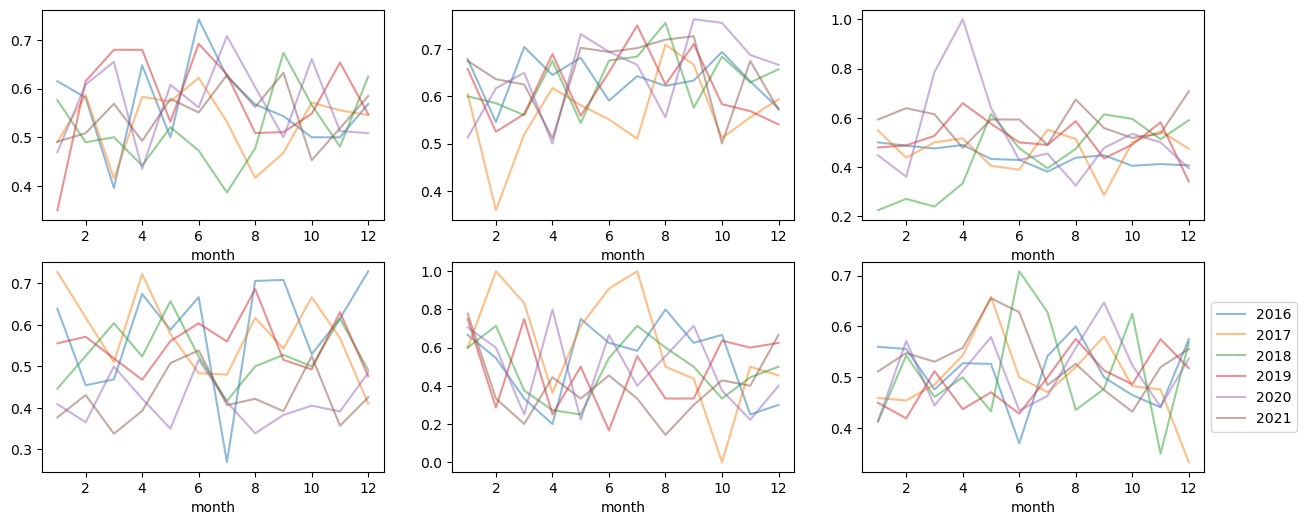

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
plot_team_severity("Addenbrooke's Hospital", 'mild', ax[0, 0], False)
plot_team_severity('Basildon University Hospital', 'mild', ax[0, 1], False)
plot_team_severity('Blackpool Victoria Hospital', 'mild', ax[0, 2], False)
plot_team_severity('Bradford and Airedale SU', 'mild', ax[1, 0], False)
plot_team_severity('Bronglais Hospital', 'mild', ax[1, 1], False)
plot_team_severity('Broomfield Hospital', 'mild', ax[1, 2], True)

In [20]:
(data_full[data_full['stroke_team'] == "Addenbrooke's Hospital"]
 .groupby('month_year')
 .size())

month_year
2016-01    39
2016-02    43
2016-03    48
2016-04    54
2016-05    42
           ..
2021-08    48
2021-09    49
2021-10    53
2021-11    54
2021-12    53
Freq: M, Length: 72, dtype: int64

## Arriving by ambulance

The proportion arriving by ambulance declines from 2016 to 2019, but with a notable increase with the start of the COVID-19 pandemic, and then a large decline to the end of 2021 (with another, smaller increase for the second/third lockdown).

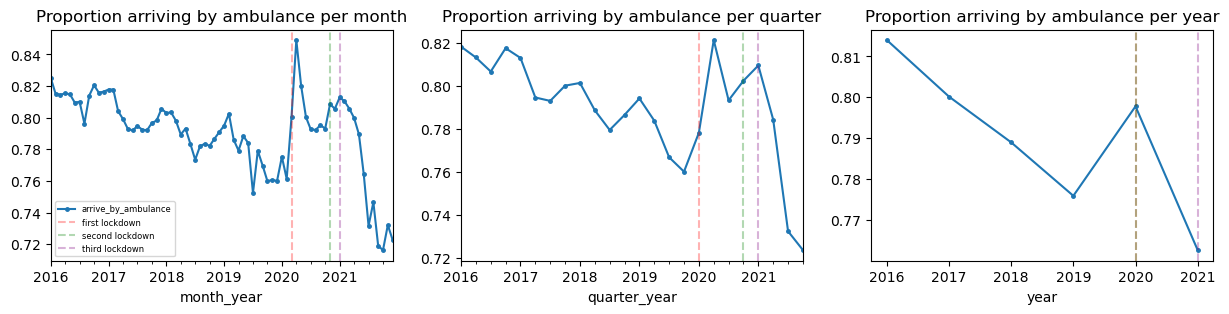

In [21]:
create_line_plots('arrive_by_ambulance', 'mean',
                  'Proportion arriving by ambulance')

These graphs now focus on **median ambulance times**.

Observations:
* **Call to ambulance arrival time** from 2019 became shorter in 2020 but then longer in 2021
* **Ambulance on scene time** from 2019 has become longer in 2020 and 2021
* **Travel to hospital time** appears fairly consistent
* **Hospital wait time** appears fairly consistent

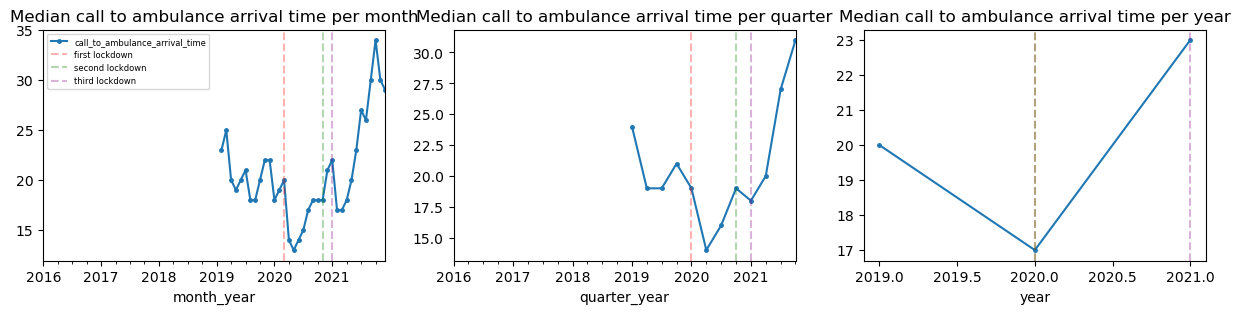

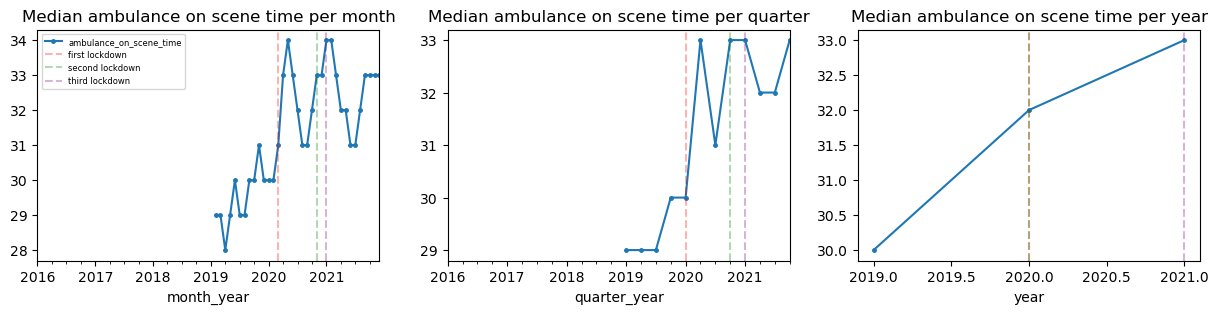

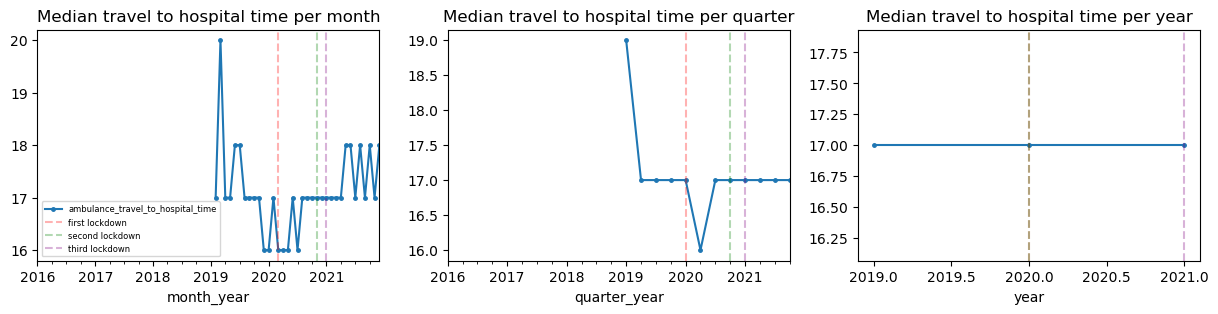

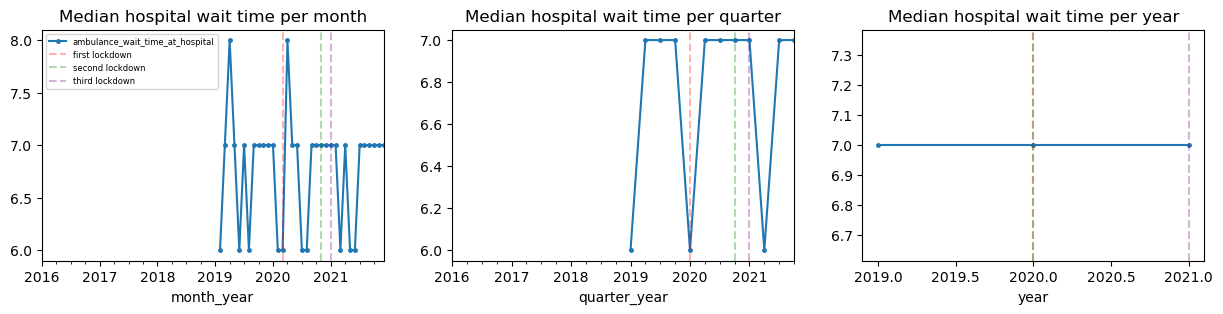

In [22]:
create_line_plots('call_to_ambulance_arrival_time', 'median',
                  'Median call to ambulance arrival time')
create_line_plots('ambulance_on_scene_time', 'median',
                  'Median ambulance on scene time')
create_line_plots('ambulance_travel_to_hospital_time', 'median',
                  'Median travel to hospital time')
create_line_plots('ambulance_wait_time_at_hospital', 'median',
                  'Median hospital wait time')

## Comorbidities

Observations:
* Proportion with congestive heart failure does not have consistent trend over time
* Proportion with hypertension is increasing slightly
* Proportion with atrial fibrillation is decreasing slightly
* Proportion with diabetes is increasing slightly
* Proportion with prior stroke or TIA is decreasing slightly

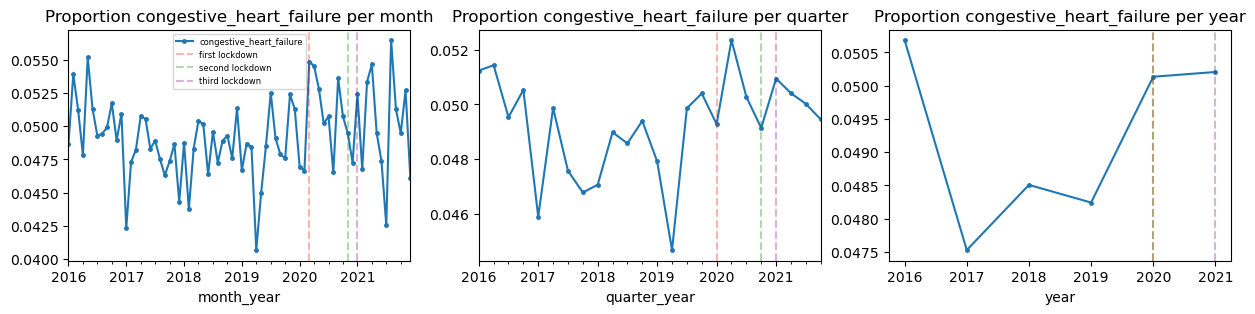

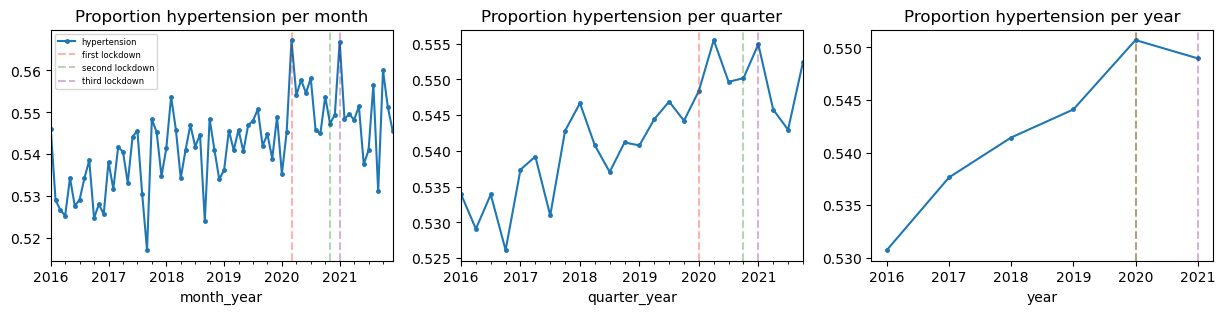

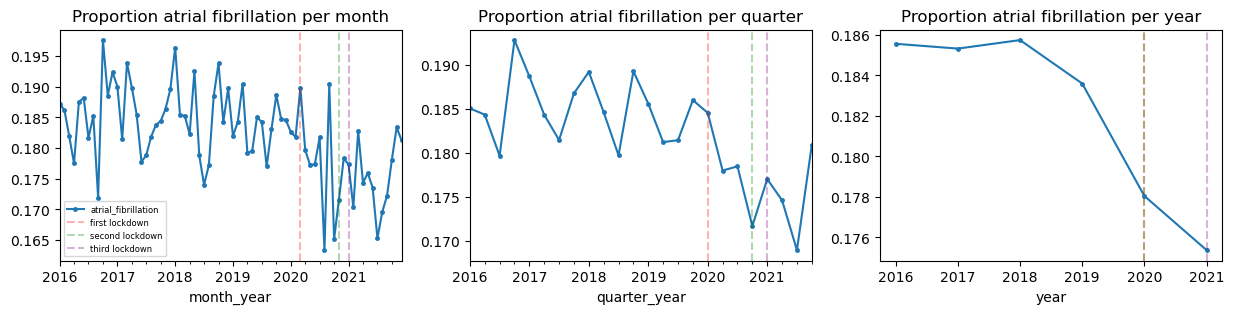

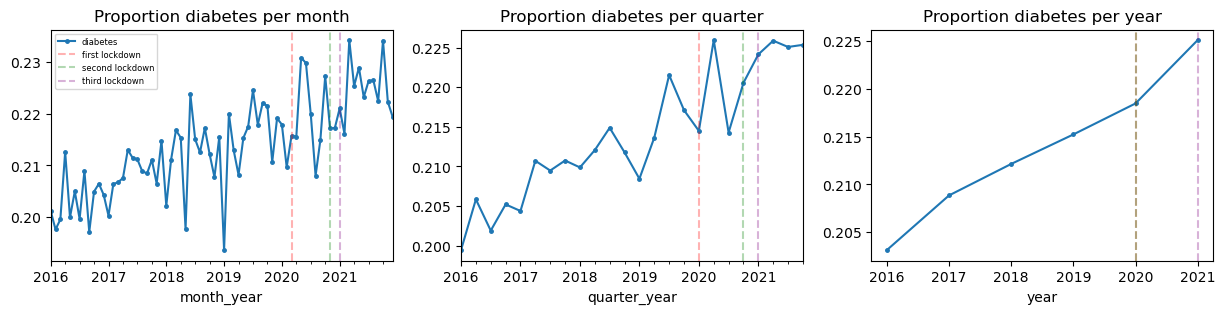

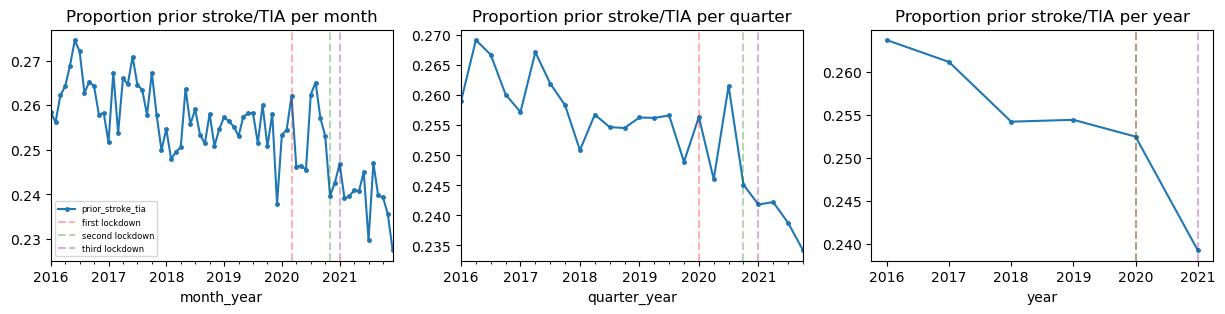

In [23]:
create_line_plots('congestive_heart_failure', 'mean',
                  'Proportion congestive_heart_failure')
create_line_plots('hypertension', 'mean',
                  'Proportion hypertension')
create_line_plots('atrial_fibrillation', 'mean',
                  'Proportion atrial fibrillation')
create_line_plots('diabetes', 'mean',
                  'Proportion diabetes')
create_line_plots('prior_stroke_tia', 'mean',
                  'Proportion prior stroke/TIA')

## Antiplatelets and anticoagulants

Observations:
* Proportion on antiplatelets is decreasing over time
* Proportion on anticoagulants is incredibly high (50%) and then drops in 2018 <mark> likely data quality issue - need to look into more </mark>

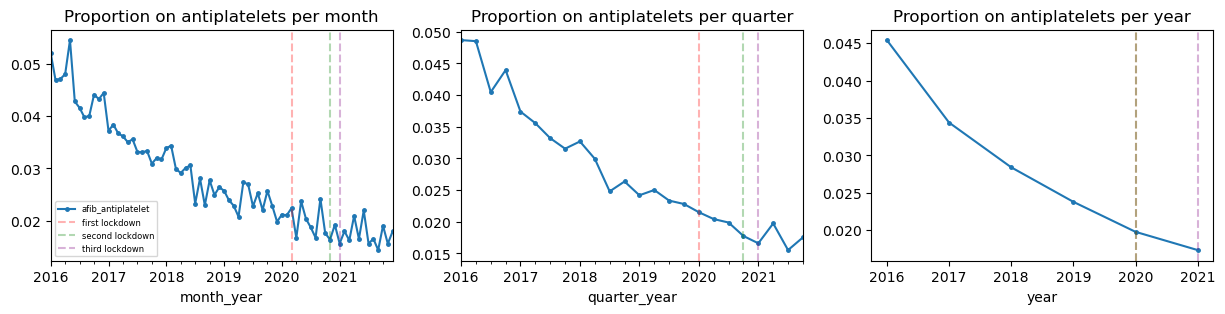

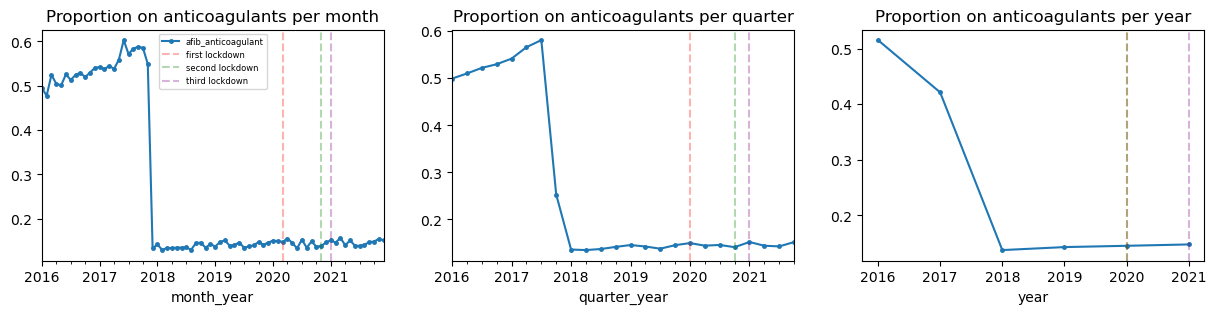

In [24]:
create_line_plots('afib_antiplatelet', 'mean',
                  'Proportion on antiplatelets')
create_line_plots('afib_anticoagulant', 'mean',
                  'Proportion on anticoagulants')

## Prior disability

Observations:
* No major trends over time or with COVID-19 pandemic.

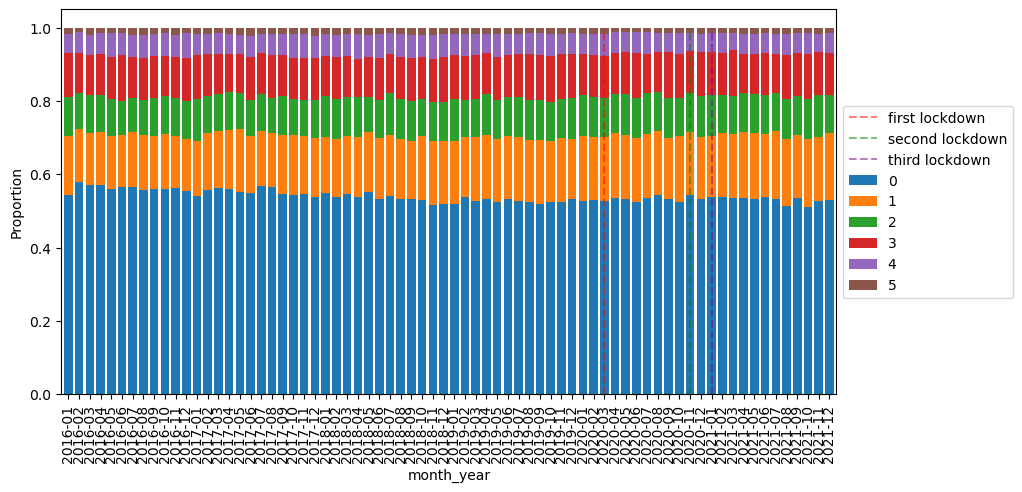

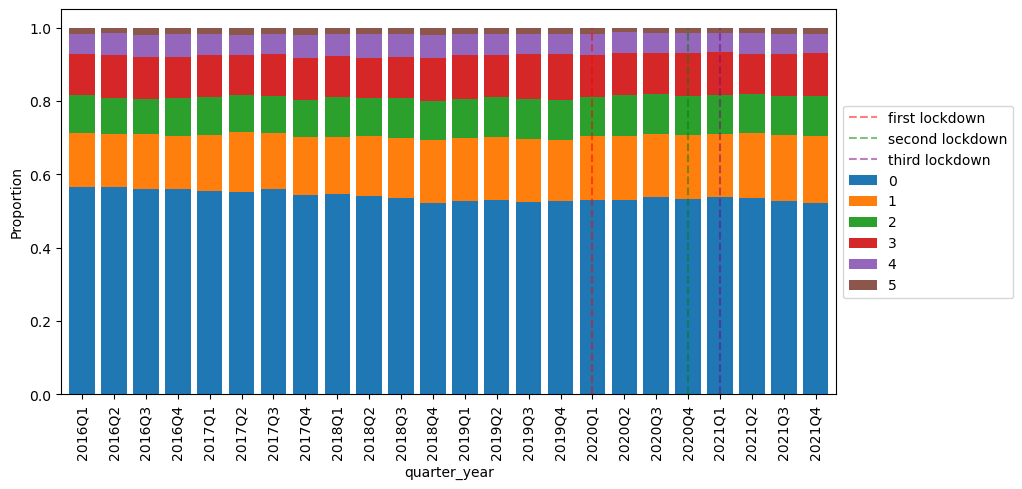

In [25]:
plot_stacked_bar('month_year', 'prior_disability')
plot_stacked_bar('quarter_year', 'prior_disability')

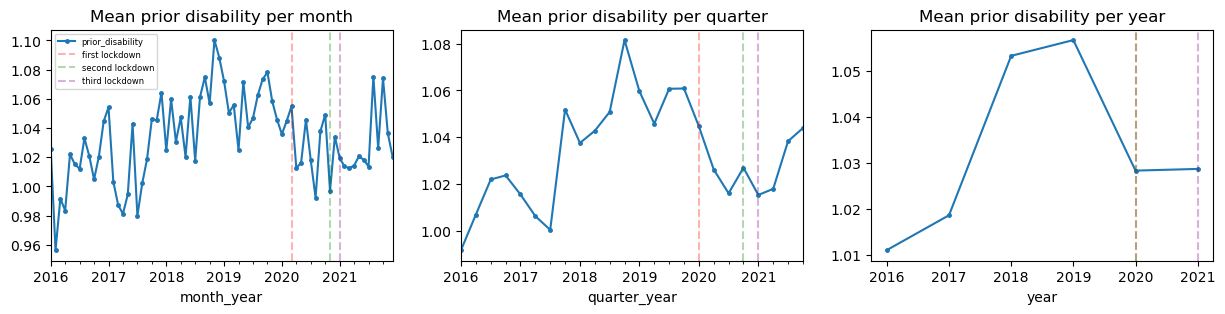

In [26]:
create_line_plots('prior_disability', 'mean', 'Mean prior disability')

## Discharge disability

Observations:
* Can't easily see any trends over time
* There is some seasonal variation (lower proportion of the worse disability scores in the summer)

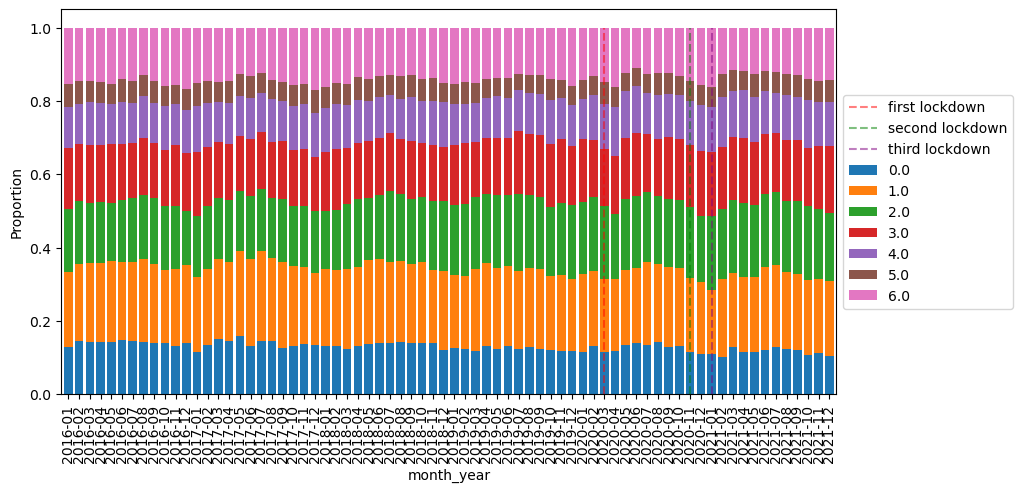

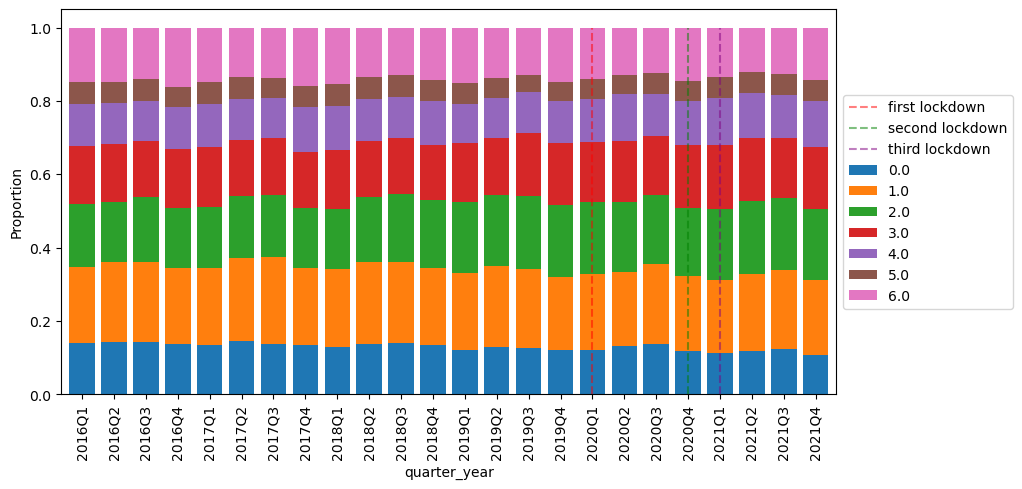

In [27]:
plot_stacked_bar('month_year', 'discharge_disability')
plot_stacked_bar('quarter_year', 'discharge_disability')

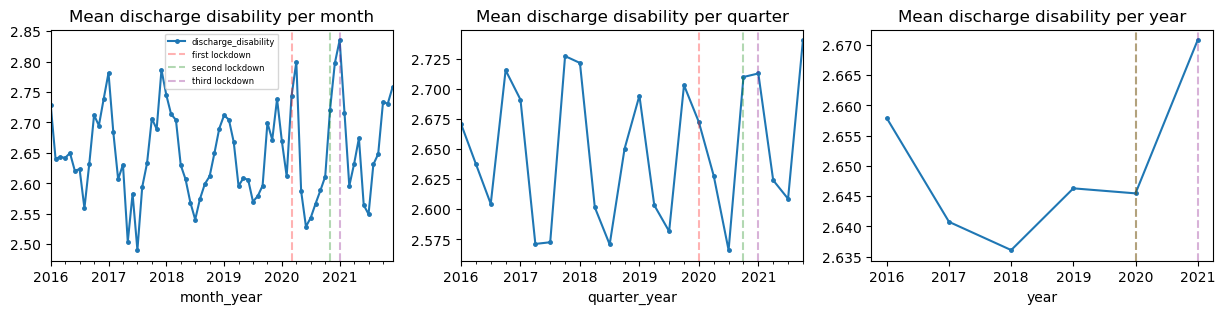

In [28]:
create_line_plots('discharge_disability', 'mean', 'Mean discharge disability')

## Disability at 6 months

Observations:
* Can't easily see seasonal variation or trends over time

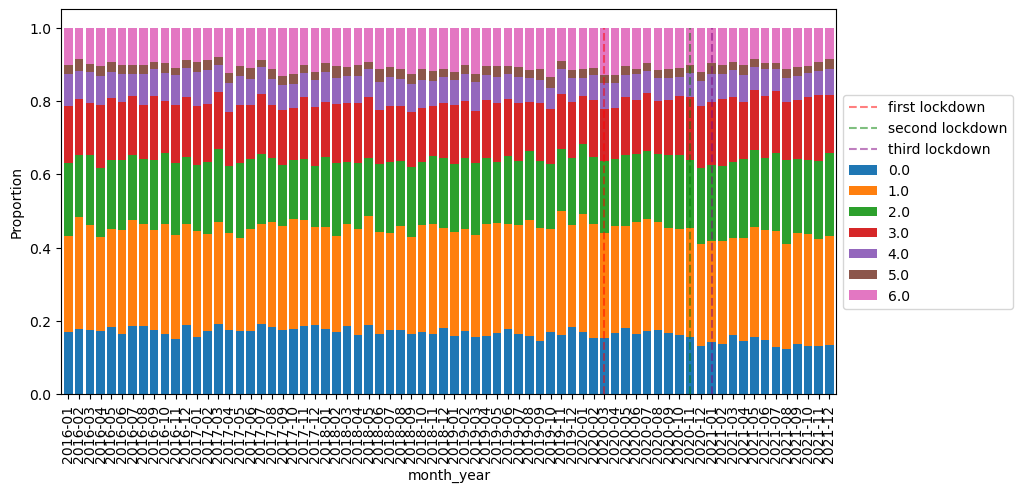

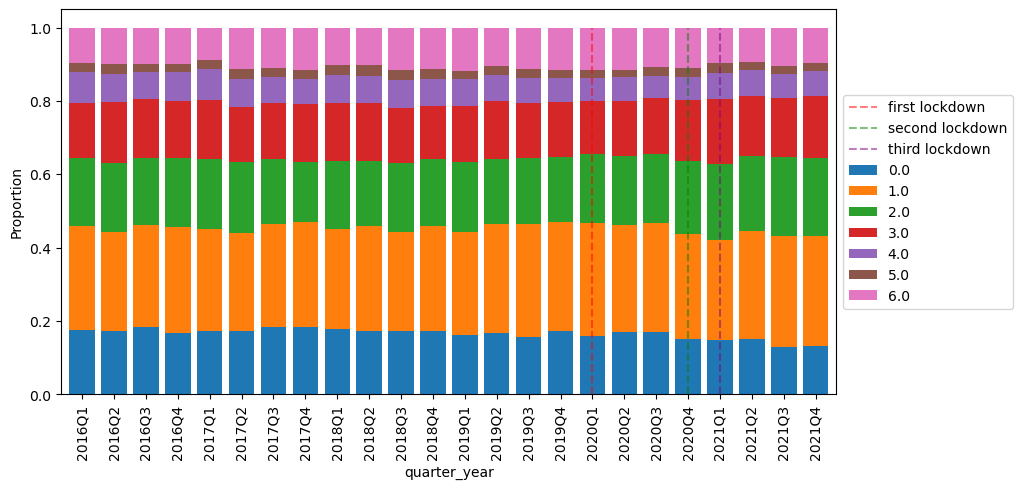

In [29]:
plot_stacked_bar('month_year', 'disability_6_month')
plot_stacked_bar('quarter_year', 'disability_6_month')

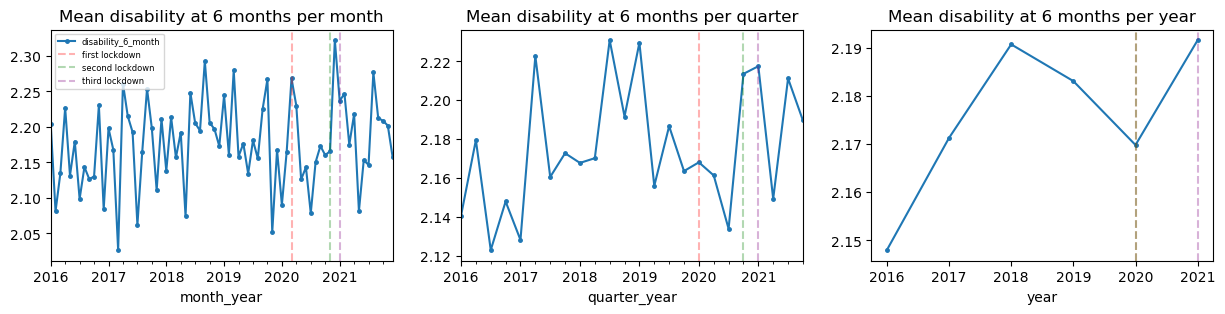

In [30]:
create_line_plots('disability_6_month', 'mean', 'Mean disability at 6 months')

## Mortality

Proportion:
* Proportion dead at discharge is generally decreasing over time
* There is seasonal variation, with typically a higher proportion dead at discharge in winter than in summer

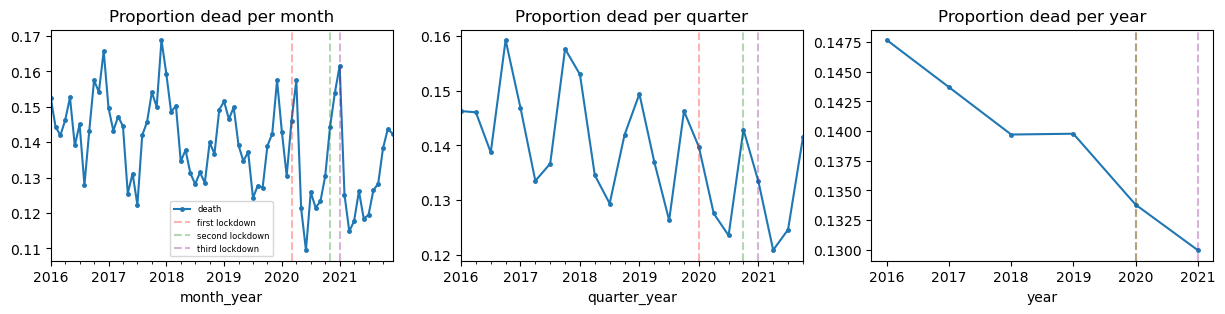

In [31]:
create_line_plots('death', 'mean', 'Proportion dead')

## Reasons for not receiving thrombolysis

Observations:
* There does not appear to be particular trends - but note, this is only available for a very very small number of patients. 

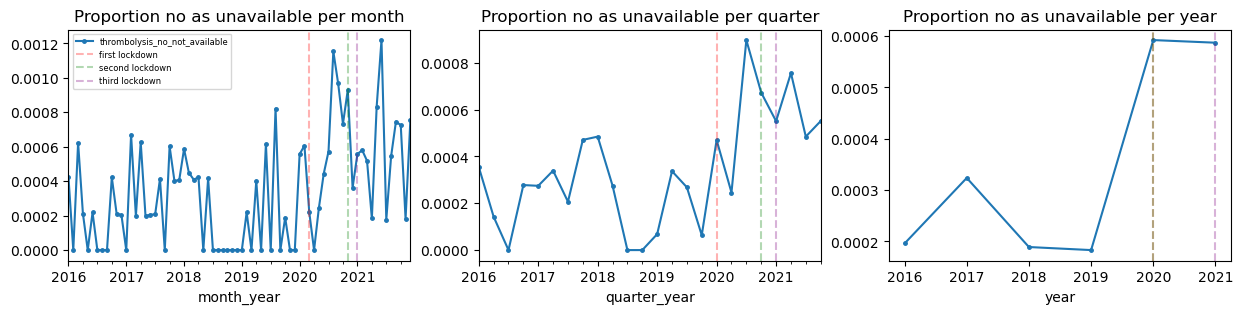

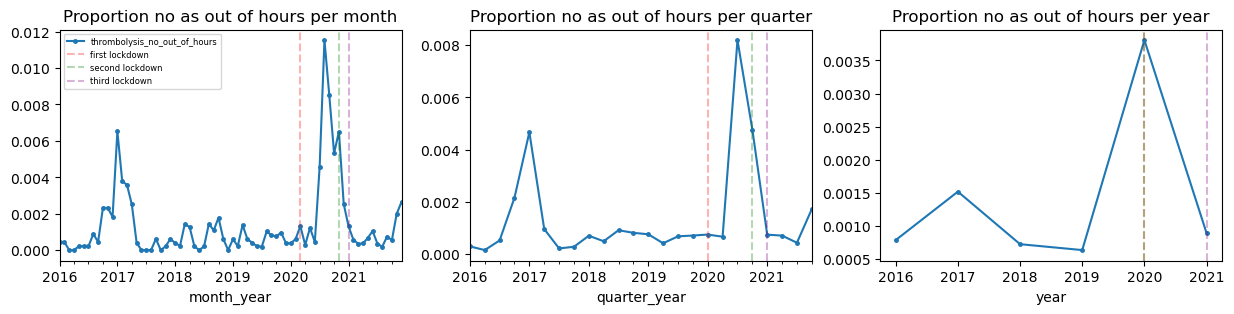

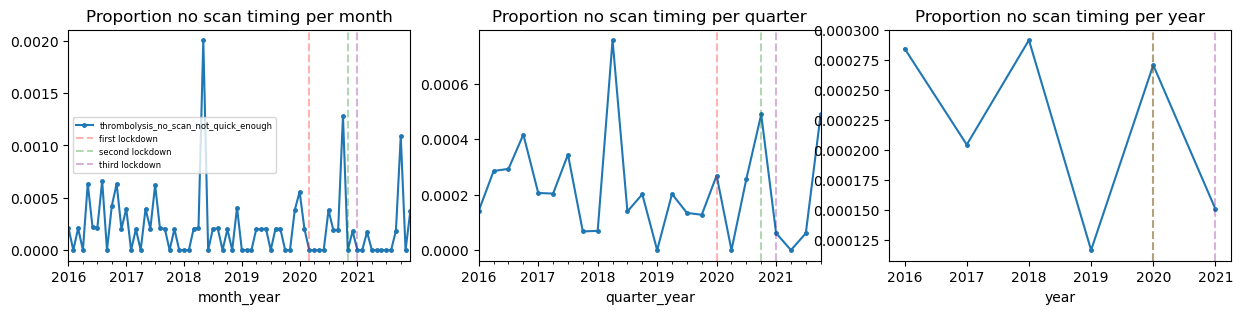

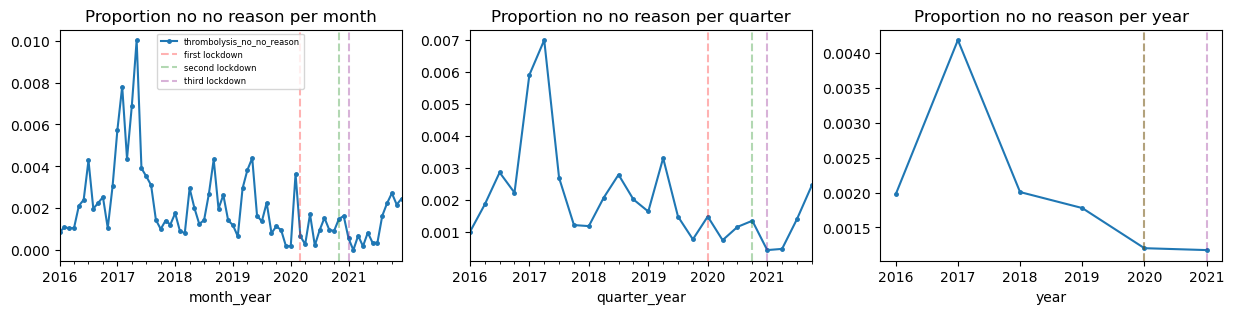

In [32]:
create_line_plots('thrombolysis_no_not_available', 'mean',
                  'Proportion no as unavailable')
create_line_plots('thrombolysis_no_out_of_hours', 'mean',
                  'Proportion no as out of hours')
create_line_plots('thrombolysis_no_scan_not_quick_enough', 'mean',
                  'Proportion no scan timing')
create_line_plots('thrombolysis_no_no_reason', 'mean',
                  'Proportion no no reason')

Observations for proportion not receiving thrombolysis due to:
* **Stroke type** - seasonal variation (higher in winter), not consistent trend across years
* **Time window** - increasing across years
* **Comorbidity** - decreasing across years
* **Medication** - increasing across years
* **Refusal** - not consistent trend across years
* **Age** - not consistent trend across years
* **Improving** - decreasing across years
* **Too mild or too severe** - not consistent trend across years 
* **Onset time unknown** - not consistent trend across years
* **Other medical reason** - not consistent trend across years

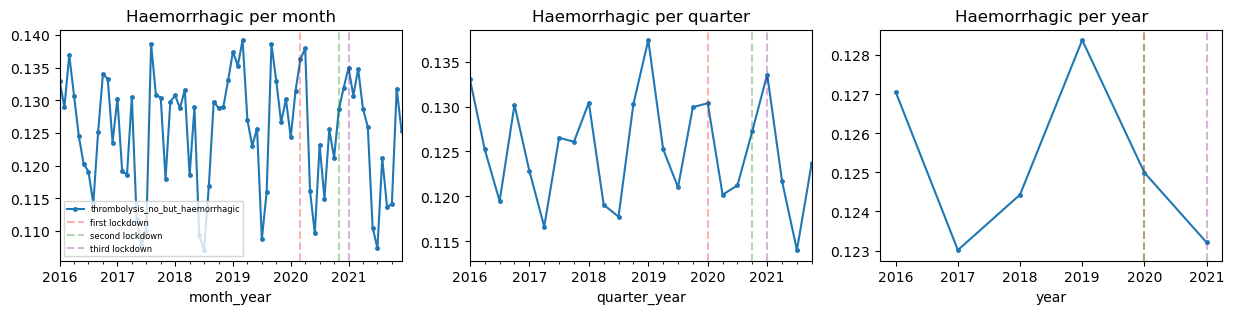

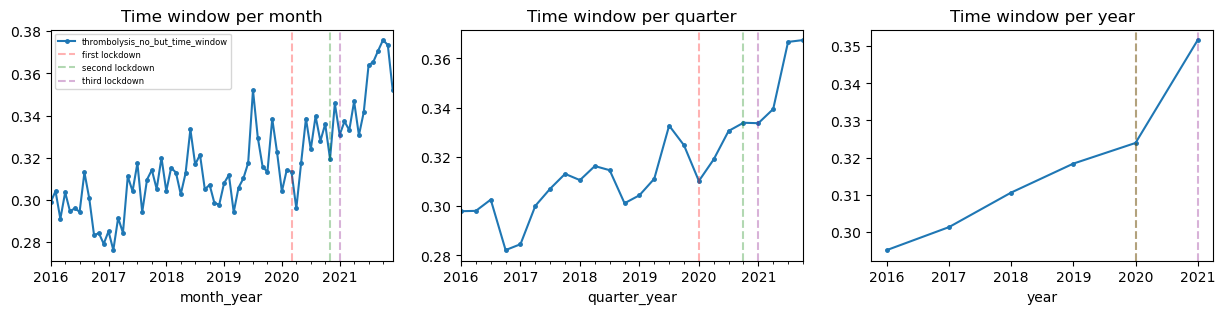

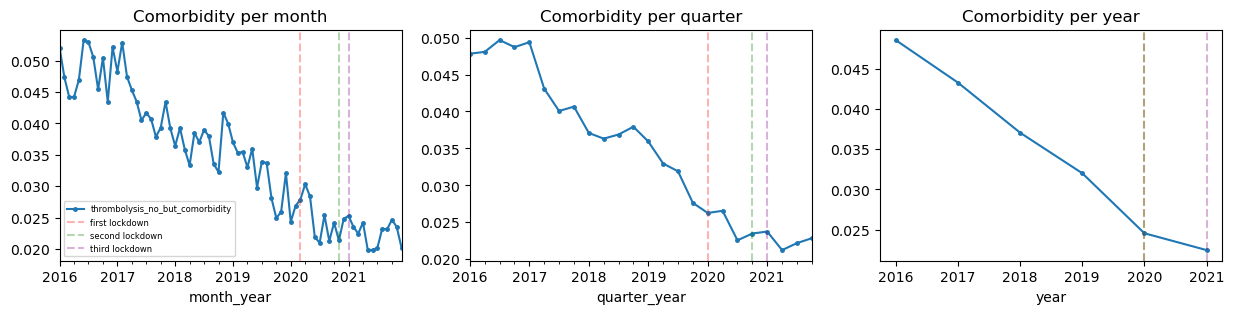

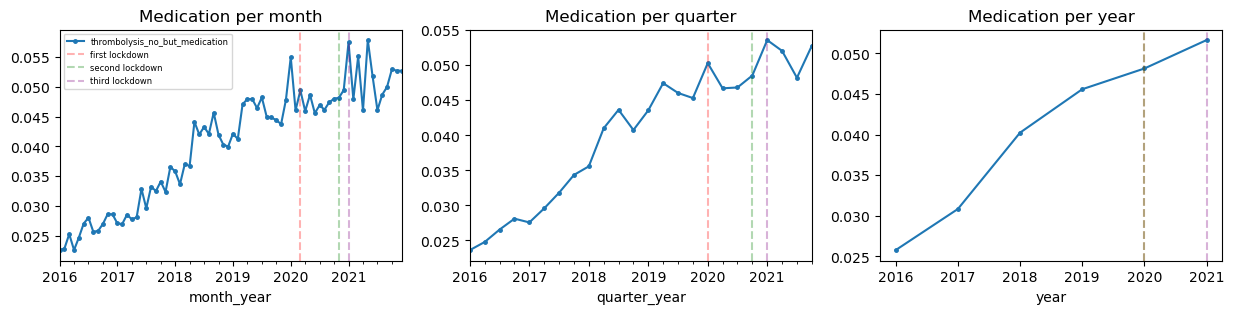

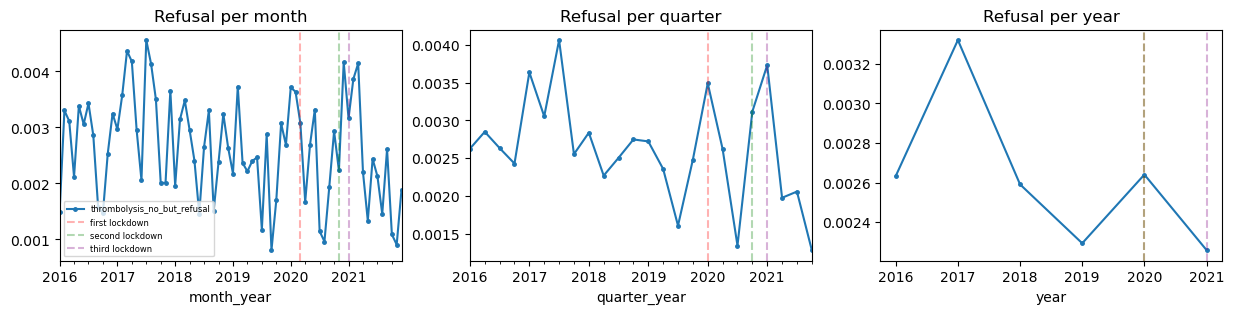

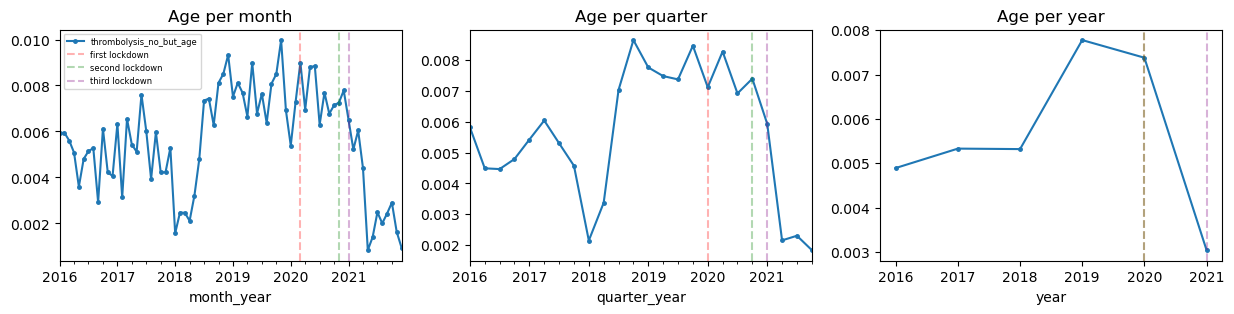

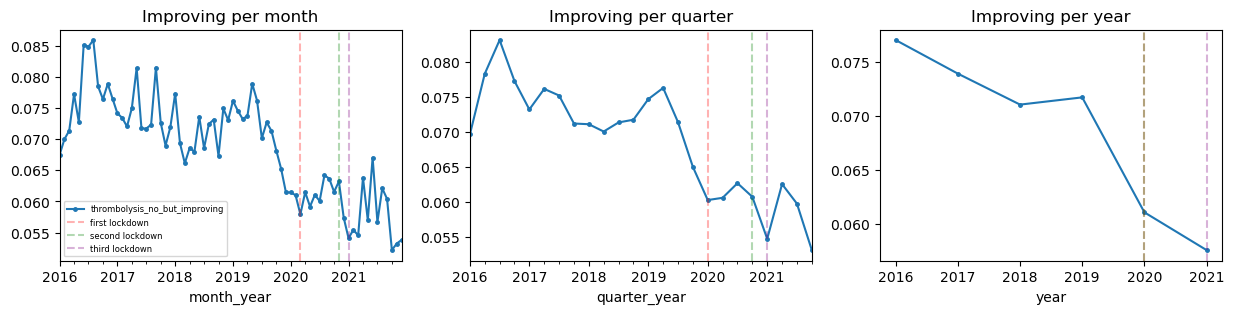

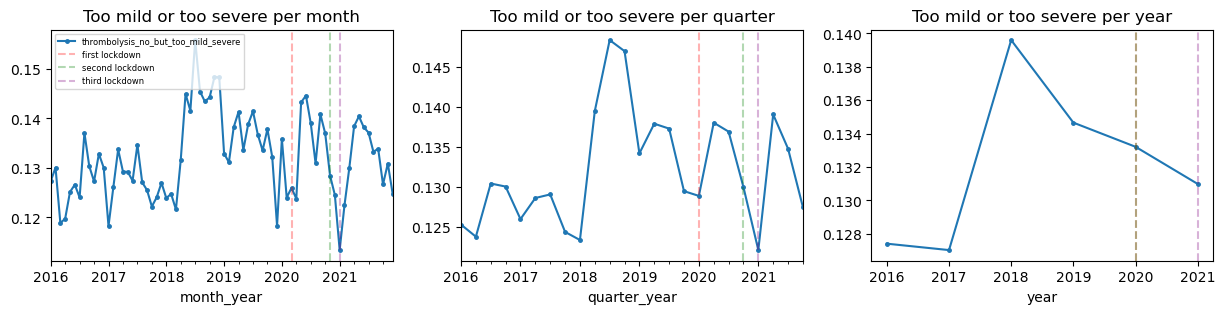

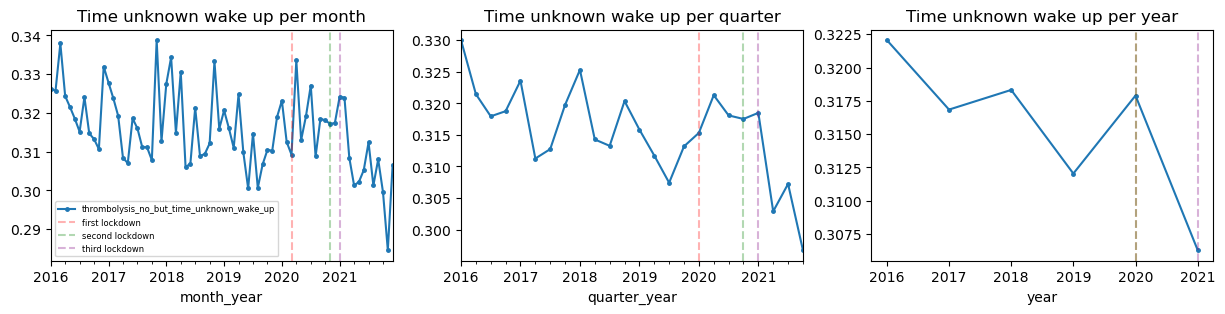

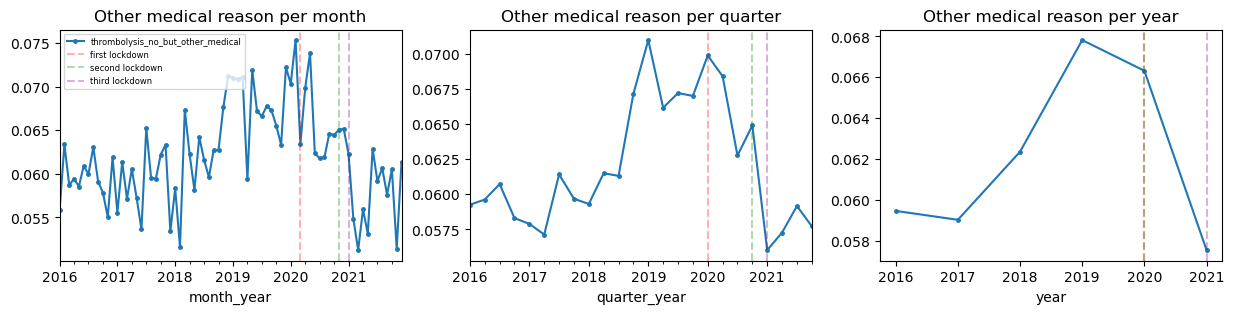

In [33]:
create_line_plots('thrombolysis_no_but_haemorrhagic', 'mean',
                  'Haemorrhagic')
create_line_plots('thrombolysis_no_but_time_window', 'mean',
                  'Time window')
create_line_plots('thrombolysis_no_but_comorbidity', 'mean',
                  'Comorbidity')
create_line_plots('thrombolysis_no_but_medication', 'mean',
                  'Medication')
create_line_plots('thrombolysis_no_but_refusal', 'mean',
                  'Refusal')
create_line_plots('thrombolysis_no_but_age', 'mean',
                  'Age')
create_line_plots('thrombolysis_no_but_improving', 'mean',
                  'Improving')
create_line_plots('thrombolysis_no_but_too_mild_severe', 'mean',
                  'Too mild or too severe')
create_line_plots('thrombolysis_no_but_time_unknown_wake_up', 'mean',
                  'Time unknown wake up')
create_line_plots('thrombolysis_no_but_other_medical', 'mean',
                  'Other medical reason')